# Jeu de base

Dans ce Notebook, nous allons définir des classes pour faire tourner notre jeu de trader.

L'idée est de pouvoir simuler les actions d'un trader :
- sa stratégie
- les montants investis
- la période de temps pour "connaître" les données
- la période de temps pour réaliser sa stratégie
- ...

Voici le plan du Notebook :
1. charger les données
2. définir une classe `Account`
3. définir une classe `Game`
4. définir une classe `Strategy`
5. définir une classe `EvalGame`

Pour toutes ces classes, le code est fourni. Il faudra donc le comprendre et le tester.

Après ce Notebook, vous pourrez commencer à implémenter des stratégies, exécuter le jeu, évaluer vos stratégies, enrichir ces classes, ...


## Chargement des données

Commençons par charger tout simplement nos données.

Plus tard, vous pourrez enrichir vos données avec d'autres valeurs mobilières (des actions, des monnaies, ...). Il faudra tester vos stratégies sur plusieurs jeux de données.

['data\\Coincodex\\coin_Cardano.csv', 'data\\Coincodex\\coin_Bitcoin.csv', 'data\\Coincodex\\coin_Ethereum.csv']
Coin loaded:  data\Coincodex\coin_Cardano.csv Cardano


**Dtypes**:


Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object


**From**:


2017-10-01 00:00:00  to  2022-08-17 00:00:00
Coin loaded:  data\Coincodex\coin_Bitcoin.csv Bitcoin


**Dtypes**:


Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object


**From**:


2010-07-16 00:00:00  to  2022-08-17 00:00:00
Coin loaded:  data\Coincodex\coin_Ethereum.csv Ethereum


**Dtypes**:


Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object


**From**:


2015-08-07 00:00:00  to  2022-08-17 00:00:00


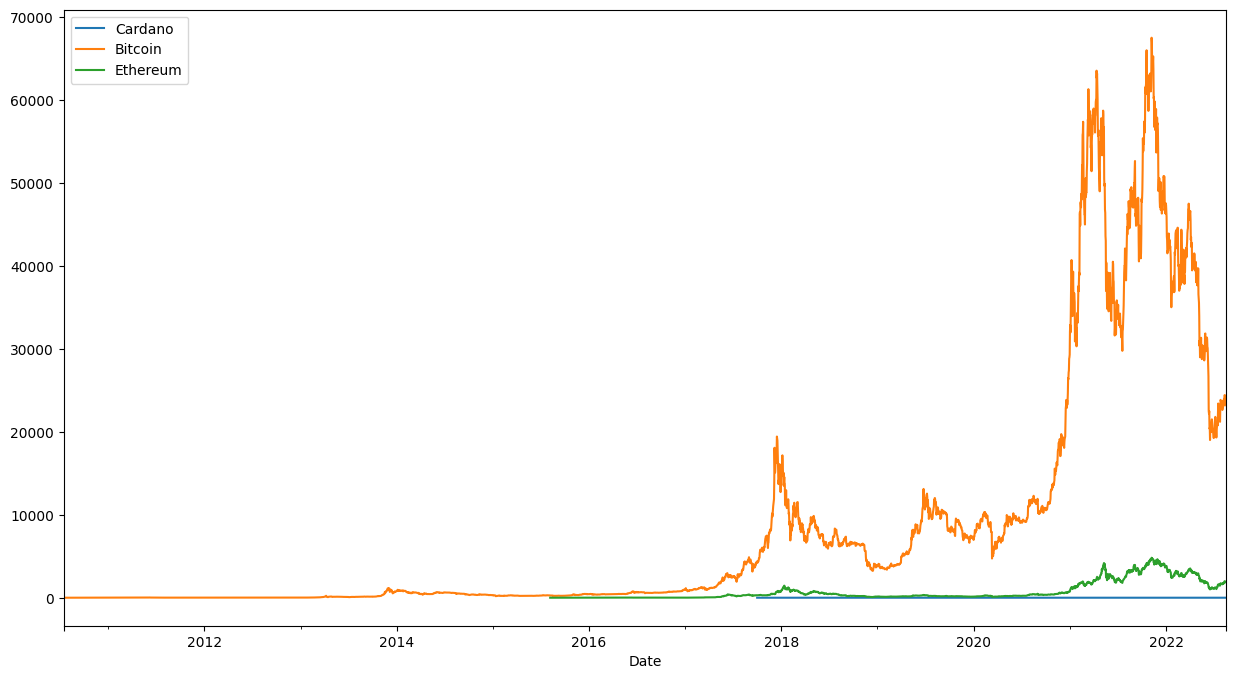

In [437]:

%run -i "05 - LoadData.ipynb"
btc = pd.read_csv('./data/Coincodex/coin_Bitcoin.csv', sep=',')
plt.rcParams['figure.figsize'] = [15, 8]

## Classes de bases du jeu

Notre programme de prédiction est composée de trois classes de bases :
- une classe `Account` représentant le compte du joueur, avec son **montant d'argent** et son **montant de valeurs mobilières** (coins/actions/bonds...)
- une classe `Game` représentant l'architecture du programme exécuté pour tester notre stratégie de vente/achat
- une classe `IStrategy`, une interface, donc une classe vide qu'il faudra ré-implémenter selon les stratégies que vous voulez appliquer
- une classe `TestGame` testant une stratégie de trader  

### Account

In [438]:
class Account :
    def __init__(self, cash=None):
        
        if (cash is None):
            self.cash = 100.0
        else:
            self.cash = cash

        self.cashInit = self.cash 
        
        self.security = 0

    def buy(self, numberOfSecurity, unityPrice):
        
        cost = unityPrice * numberOfSecurity 
        
        if(self.cash - cost >= 0):
            self.cash = self.cash - cost
            self.security = self.security + numberOfSecurity
        else:
            raise NameError("Buy error : not enough money")

    def buyMax(self, unityPrice):

        numberOfSecurity = int(self.cash / unityPrice)

        self.buy(numberOfSecurity, unityPrice)

    def sell(self, numberOfSecurity, unityPrice):

        if(self.security - numberOfSecurity >= 0):
            self.security = self.security - numberOfSecurity
            self.cash = self.cash + numberOfSecurity * unityPrice
        else:
            raise NameError("Sell error : not enought coins")

    def sellMax(self, unityPrice):
        self.sell(self.security, unityPrice)

    def isOver(self):
        return self.security == 0 and self.cash == 0.0

    def getTheoricalValue(self, unityPrice):
        return (self.cash + self.security * unityPrice)
    
    def getTheoricalGain(self, unityPrice):
        return self.getTheoricalValue(unityPrice) - self.cashInit

    ''' 
    Méthode permettant d'afficher vos objets Account de manière conviviale. Cette méthode est
    automatiquement appelée quand un objet Account est donné en argument de la fonction 'print'
    '''
    def __str__(self):
        return "Cash: "+str(self.cash)+" & Security: "+str(self.security)+" & Gains: "+str(self.cash-self.cashInit)

**Questions**:
1. créer le compte d'un joueur
2. afficher le compte de ce joueur en l'affichant via la fonction `print`. D'où vient cet affichage ?
- Il vient de la dernière ligne du bloc de code d'avant, *def __ str __(self)*
3. acheter des coins
4. vender des coins
5. dépenser tout votre argent et vérifier que la méthode `isOver` fonctionne
6. afficher le montant de votre portefeuille (celui-ci dépend de la valeur actuelle de la valeur mobilière - indiquer la valeur que vous voulez)
7. afficher vos gains (le gain dépend de la valeur actuelle de la valeur mobilière - indiquer la valeur que vous voulez)

Pour chaque questions, tester le résultat en affichant les montants restants et les coins disponibles

In [439]:
# créer, acheter, vender des coins
joueur1 = Account()
print(joueur1)


joueur1.buy(0.8,10)
print(joueur1)

joueur1.sell(0.4,10)
print(joueur1)

joueur1.buy(96,1)
print(joueur1)

joueur1.isOver()

Cash: 100.0 & Security: 0 & Gains: 0.0
Cash: 92.0 & Security: 0.8 & Gains: -8.0
Cash: 96.0 & Security: 0.4 & Gains: -4.0
Cash: 0.0 & Security: 96.4 & Gains: -100.0


False

### Game & Strategy

La classe `Game` prend une série temporelle en entrée et se configure avec une stratégie. Le jeu comprend des actions de base :
- acheter `BUY`
- vendre `SELL`
- ne rien faire `STILL`

Voici les tâches réalisées quand le jeu s'exécute (méthode `run`):
1. lecture d'une valeur de la série temporelle
2. sélection d'une action en fonction de la stratégie testée : la stratégie prend une décision en fonction de la valeur lue et retourne un couple (action, montant de valeur mobilière), par exemple `(BUY, 150)` pour acheter 150 valeurs mobilières
3. application de l'action sur le compte du tradeur

Voici, ci-dessous, la classe `Game`. En résumé, cette classe contient :
- les actions `BUY`, `SELL`, `STILL`
- un constructeur prenant en paramètre la série temporelle, un `Account` et une `Strategy` de trading
- deux setteurs permettant d'initialiser (ou mettre à jour) le `Account` et la `Strategy` du jeu
- la méthode `run` parcourant une à une la série temporelle, récupérant l'action (action, montant) de la stratégie à partir de la valeur du jour. L'action est appliquée sur le compte
- une méthode `getTheoricalValue` retournant la valeur théorique du `Account` (théorique car cela suppose que l'on revende toutes nos valeurs mobilières au cours du jour)
- une méthode `getTheoricalGain` retournant le gain théorique, soustrayant le montant initial à notre valeur théorique


In [440]:

class Game :

    '''
    Définition des variables appartenant à la classe, et non pas aux objets
    '''
    BUY = 0
    SELL = 1
    STILL = 2

    ACTIONS = ["BUY", "SELL", "STILL"]

    def __init__(self, serie, account=None, strategy=None):
        self.dates = serie.index
        print(self.dates)
        self.serie = serie.tolist()
        self.account = account
        self.strategy = strategy
        self.clock = 0
        
    def setStrategy(self, strategy):
        self.strategy = strategy

    def setAccount(self, account):
        self.account = account
        self.clock = 0

    def run(self, debug=False):

        if(self.account is None):
            raise NameError("Account is not set")
        
        if(self.strategy is None):
            raise NameError("Strategy is not set")
        
        for unityPrice in self.serie:
            
            (action, amountOfSecurity) = self.strategy.getAction(self, unityPrice, self.dates[self.clock], debug)

            if(action == Game.BUY):
                actionStr = "BUY "
            elif(action == Game.SELL):
                actionStr = "SELL "
            elif(action == Game.STILL):
                actionStr = "STILL "

            if debug:
                print("---", actionStr, amountOfSecurity, "securities at clock ", self.clock)

            if(self.account.isOver()):
                break;

            try:
                if(action == Game.BUY):
                    self.account.buy(amountOfSecurity, unityPrice)
                elif(action == Game.SELL):
                    self.account.sell(amountOfSecurity, unityPrice)
                else:
                    pass
            except NameError as error:
                if debug:
                    print(error)

            if debug:
                print(self.account)
                
            self.clock = self.clock+1

    def getTheoricalValue(self):
        return self.account.getTheoricalValue(self.serie[-1])
    
    def getTheoricalGain(self):
        return self.account.getTheoricalGain(self.serie[-1])

    def __str__(self):
        return "Game after "+str(self.clock)+"/"+str(len(self.serie))+" steps - "+str(self.account)
    

**Questions**: 
1. lire la classe `Game`
2. instancier un objet `game`, à partir de la classe `Game`
3. exécuter la méthode `run`. Que se passe-t-il ?
- Erreur. Il faut set un account
4. initialiser le `Account` de `game` avec l'objet `account` créé précédemment
5. exécuter la méthode `run`. Que se passe-t-il ?
- "Strategy is not set"
6. continuer à lire le Notebook, pour découvrir la classe `Strategy`


In [441]:
btc

,Date,Open,High,Low,Close,Volume,Market Cap
0,Aug-17-2022,23338.393004,23575.6112,23140.458575,23206.185200,5.097574e+10,4.478307e+11
1,Aug-16-2022,23858.860419,24416.5980,23213.059028,23311.759147,5.559294e+10,4.532567e+11
2,Aug-15-2022,24088.535700,24236.6282,23707.543900,23889.746060,5.913368e+10,4.583451e+11
3,Aug-14-2022,24300.943040,25136.0173,23804.716600,24146.605700,5.926712e+10,4.639056e+11
4,Aug-13-2022,24443.207718,24975.3551,24177.632915,24323.002169,4.503609e+10,4.685056e+11
...,...,...,...,...,...,...,...
4411,Jul-20-2010,0.079200,0.0792,0.079200,0.079200,0.000000e+00,0.000000e+00
4412,Jul-19-2010,0.074700,0.0747,0.074700,0.074700,0.000000e+00,0.000000e+00
4413,Jul-18-2010,0.080800,0.0808,0.080800,0.080800,0.000000e+00,0.000000e+00
4414,Jul-17-2010,0.085800,0.0858,0.085800,0.085800,0.000000e+00,0.000000e+00


In [442]:
# Instanciation de Game
%run -i "Strategies.ipynb"


joueur2 = Account(100)
strategy2 = StrategyOracle()

liste2 = pd.Series(btc.loc[:, 'Open'])
game2 = Game(liste2,joueur2,strategy2)

print("--------------")
print("Dates = ", game2.dates[0])

print("--------------")
print("Serie =", game2.serie[0])

print("--------------")
print("Account =", game2.account)

print("--------------")
print("strategy  =", game2.strategy)

print("--------------")
print("clock =", game2.clock)
print("--------------")
print(game2.run())

RangeIndex(start=0, stop=4416, step=1)
--------------
Dates =  0
--------------
Serie = 23338.393003726764
--------------
Account = Cash: 100 & Security: 0 & Gains: 0
--------------
strategy  = <__main__.StrategyOracle object at 0x0000014E0B4AA320>
--------------
clock = 0
--------------
None


Pour exécuter un jeu, il nous faut donc un instance de `Strategy`. Voici ci-dessous la classe de base `Strategy` : cette classe est un squelette que toutes vos classes stratégies vont devoir respecter. 
L'utilité de respecter ce squelette est de pouvoir utiliser toutes vos stratégies avec la classe `Game` précédente.

Cette classe est définie par :
- un constructeur, dans lequel on pourra initialiser des variables, suivant notre stratégie
- une méthode `getAction` prenant en paramètre un objet `Game`, un prix actuel `unityPrice`, la date de ce prix et un paramètre `debug` indiquant si il faut afficher des messages quand cette fonction est appelée

In [443]:
class IStrategy :

    def __init__(self):
        pass

    def getAction(game, unityPrice, date, debug=False):
        '''
        @return (action, amountOfSecurity)
        '''
        pass

`IStrategy` est une classe de base, utile ici simplement pour vous indiquer quelle tête vos futures stratégies doivent avoir pour fonctionner avec `Game`. Vos stratégies doivent donc avoir la même tête, c'est à dire, les mêmes méthodes.

Pour être sûr d'avoir la même tête, il faut que vos stratégies héritent de la classe `IStrategy`. Et voici comment faire :

In [444]:
class MaNouvelleStrategy(IStrategy):

    def __init__(self):
        super().__init__()

    def getAction(self, game, unityPrice, date, debug=False):
        '''
        implementation de votre algorithme ici

        vous connaissez le prix du jour unityPrice, la date du jour

        vous avez accès aux anciens prix, au compte via game

        donc il vous reste plus qu'à prendre une décision
        et retourner votre action sous forme de tuple (0, 10) pour acheter 10 valeurs mobilières par exemple

        Ou bien (1, 5) pour en vendre 5
        '''
        pass
        

**Questions** :
1. créer un Notebook `Strategies.ipynb`
2. charger le Notebook `Strategies.ipynb` dans ce Notebook
3. dans le fichier `Strategies.ipynb`, ajouter une classe stratégie `StrategyLongTerm`. Bien entendu, cette classe hérite de la classe `IStrategy` et vérifiera son squelette. La stratégie `LongTerm` consiste à dépenser tout votre argent à une date décidée, à les garder, puis tout revendre aujourd'hui
3. dans le fichier `Strategies.ipynb`, ajouter une classe stratégie `StrategyRandom`. Bien entendu, cette classe hérite de la classe `IStrategy` et vérifiera son squelette. La stratégie `Random` consiste à choisir au hasard l'action réalisée, le montant d'achat ou de vente (montant dans les bornes du cash et des valeur mobilières disponibles)
4. dans le fichier `Strategies.ipynb`, ajouter une classe stratégie `StrategyOracle`. La stratégie `Oracle` est la meilleure stratégie possible, et sous entend que l'on puisse déterminer le futur : on vend au plus haut et on rachète quand on est au plus bas. Cela revient à détecter les minimum et maximum locaux. Toutes les stratégies que nous implémenterons dans la suite pourront ainsi être comparées à la stratégie `Oracle`. 

Chargez ici votre fichier stratégies :

In [445]:
# chargement du Notebook Strategies.ipynb
%run -i "Strategies.ipynb"


Testez maintenant vos stratégies, voici un squelette d'exemple :

In [446]:
import pandas as pd
%run -i "Strategies.ipynb"



strategy1 = StrategyLongTerm()
strategy2 = StrategyOracle()


account1 = Account(100)
account2 = Account(100)


serie1 = pd.Series([0,1])
game = Game(serie1,account=account1,strategy=strategy1)
serie2 = pd.Series([btc])
game2 = Game(serie2,account=account2,strategy=strategy2)

game.run()


RangeIndex(start=0, stop=2, step=1)
RangeIndex(start=0, stop=1, step=1)


ZeroDivisionError: division by zero

## EvalGame

Il nous reste maintenant à présenter la classe `EvalGame` : celle-ci sert à exécuter automatiquement un nombre X de fois un jeu avec une stratégie associée. Certaines stratégies ayant des comportements stochastique (_Se dit de phénomènes qui, partiellement, relèvent du hasard et qui font l'objet d'une analyse statistique_), chaque exécution donnera un résultat différent. Pour les évaluer, il est nécessaire d'aggréger le résultat de plusieurs exécution.

Par exemple :
- notre stratégie `Random` rend tous le temps un résultat différent. Il est nécessaire de calculer le gain moyen de cette stratégie pour l'évaluer
- notre stratégie `Oracle` est par contre déterministe. Chaque itération génére le même résultat

Une courte description de la classe 'EvalGame':
- un constructeur prenant en paramètre une série temporelle, un montant initial de cash pour le `Account` et une `Strategy`
- une méthode `setStrategy` pour initialiser/mettre à jour la stratégie du jeu
- une méthode `eval` prenant le nombre d'execution du `Game` et un paramètre `debug` indiquant si il faut afficher les actions réalisées par le jeu
- la méthode `eval` réalise `iteration ` fois :
    1. création d'un `Account`
    2. exécution du jeu avec sa stratégie
    3. stockage du gain théorique (si l'on revendait toutes nos valeurs mobilières à la fin de la série temporelle)
- une méthode `getResults` retournant la liste des gains de chaque itération

In [ ]:
class EvalGame:

    def __init__(self, serie, initialAmount=100, strategy=None):
        self.game = Game(serie)
        self.game.setStrategy(strategy)
        self.initialAmount = initialAmount        
        self.results = []

    def setStrategy(self, strategy):
        self.game.setStrategy(strategy)

    def eval(self, iteration=1000, debug=False):
        
        self.results = []

        for i in range(0, iteration):
            account = Account(self.initialAmount)
            
            if(debug):
                print("init account:", account)
            self.game.setAccount(account)
            self.game.run(debug=debug)

            score = self.game.getTheoricalGain()
            self.results.append(score)

            if debug:
                print("score[", i, "]: ", score)    

    def getResults(self):
        return self.results

    def __str__(self):
        return "Avg:"+str(np.mean(self.results))+" Min: "+str(np.min(self.results))+" Max:"+str(np.max(self.results))

**Questions** :
1. instancier un objet `eval` à partir de la classe `EvalGame`, en utilisant la série temporelle précédente et la `StrategyRandom`
2. exécuter le jeu avec 100 itérations et afficher le résultat
3. exécuter le jeu avec 1000 itérations et afficher le résultat
3. afficher, pour les 2 tests précédents, un histogramme avec la fonction de densité. Pour ce faire, rechercher sur Google avec les mots clés suivant `seaborn hist density` (pour la densité, regarder le paramètre `kde`)
4. quel est le gain moyen avec une stratégie aléatoire ?
- -49.70377890030003
5. tester votre objet `eval` en lui donnant la `StrategyOracle`. Obtenez vous bien le même résultat à chaque itération ? avez vous trouvé facile de réaliser un autre test en changeant de stratégie ?
- Fonctionne pas

RangeIndex(start=0, stop=4416, step=1)
<bound method EvalGame.getResults of <__main__.EvalGame object at 0x0000014E21667DC0>>


AttributeError: 'list' object has no attribute 'mean'

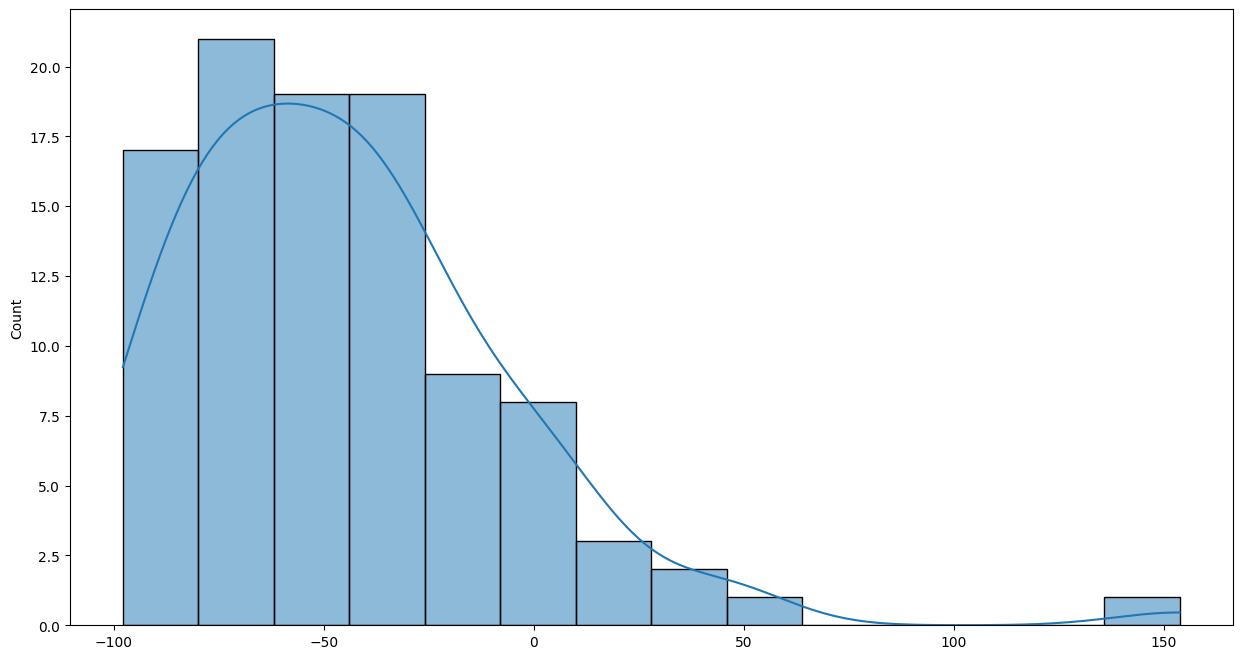

In [461]:
%run -i "Strategies.ipynb"
serie1 = pd.Series(btc.loc[:, 'Open'])

strategy1 = StrategyLongTerm()
strategy2 = StrategyOracle()
strategy3 = StrategyRandom()
eval = EvalGame(serie=serie1,strategy=strategy3,initialAmount=100)

eval.eval(iteration = 100, debug = False)

import seaborn as sns
sns.histplot(data = eval.getResults(), kde = True)

result = sum(eval.results) / len(eval.results)

print("Moyenne =",(result))


eval = EvalGame(serie=serie1,strategy=strategy1,initialAmount=100)
sns.histplot(data = eval.getResults(), kde = True)


<Axes: ylabel='Count'>

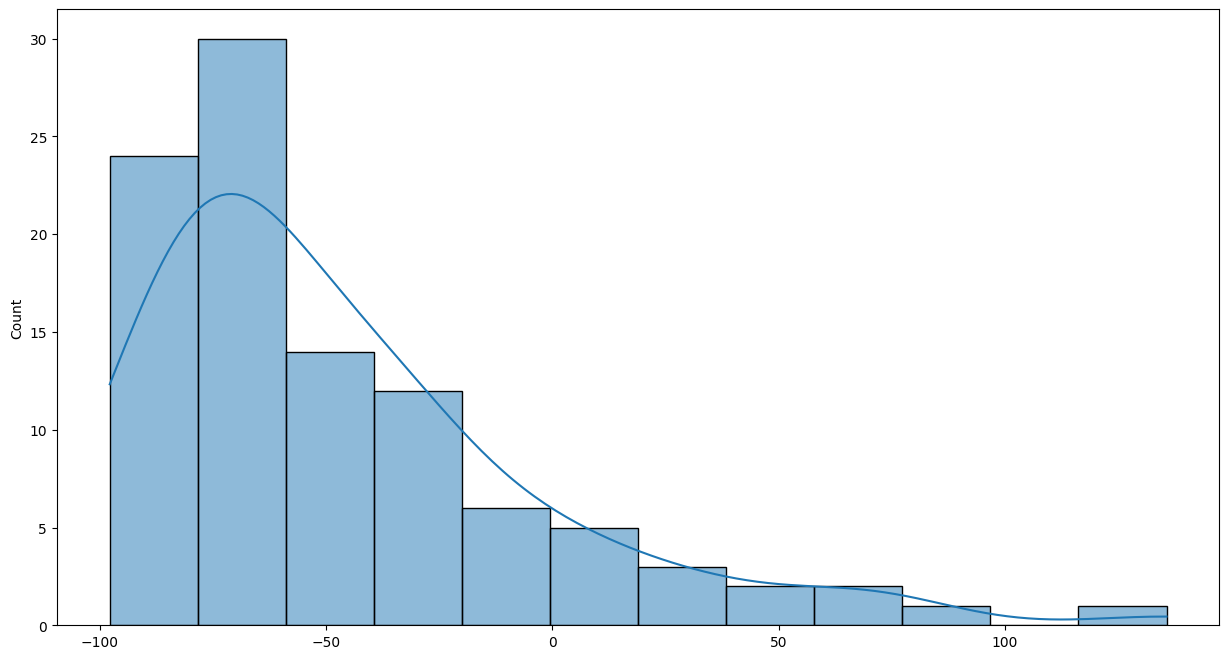

In [ ]:
data = dataCoins(ada)

## Conclusion

Félicitation !

Vous êtes maintenant prêt pour implémenter vos propres stratégies :
- vous avez seulement à ajouter votre stratégie dans le fichier `Strategies.ipynb` (s'il devient trop long, vous pouvez le couper en 2)
- vous pouvez maintenat créer un autre notebook `Game.ipynb`, en y mettant les classes du jeu, et ainsi vos notebooks auront juste à charger les données, les classes du jeu et les stratégies via vos fichiers `LoadData.ipynb`, `Game.ipynb` et `Strategies.ipynb`. Vous pouvez par exemple créer un notebook `TestStrategyDeBase.ipynb` pour y tester les stratégies les plus simples.